## Gravity 3D forward model ##

This is the most current version of the 3D gravity forward code

Coordinates organised similarly to node arrays -- receivers can be 1D, 2D, 3D now. 

### Input density is in g/kg^3 currently! ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from discretize.utils import mkvc
from scipy.constants import G

### Load / alter model ###

Original model was created using the <code>SimPEG - discretize</code> toolbox.

In [20]:
model1d=np.load(file='Test_data.npy')

# Simple density change of loaded model (background density=10)
model1d[model1d > 10] = 2000
model1d[model1d ==10] = 0


### Define some functions ### 

In [3]:
def cartesian(arrays, out=None):
    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size) 
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out


### Test model: Low background density with cube of higher density in the middle ###

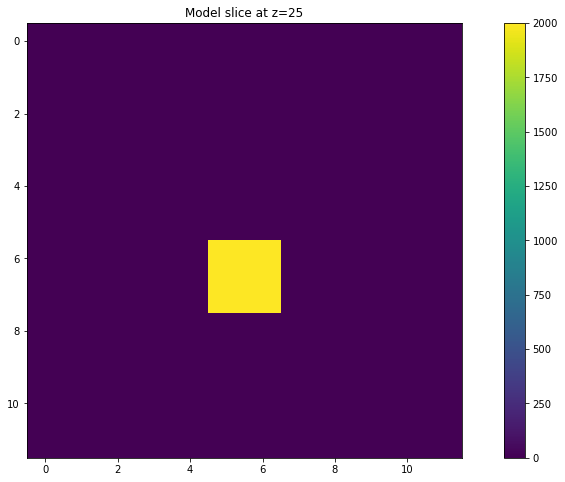

In [4]:
model2d=model1d.reshape(12,12,12)
fig = plt.figure(figsize=(15, 8))
plt.title("Model slice at z=25")
plt.imshow(model2d[:,:,5])
plt.colorbar()
plt.show()

### Create model geometry ###
I.e. create node vectors for x, y, z.

In [5]:
# Create array of all nodes for each direction
x_node_slice=np.linspace(-30,30,len(model2d)+1) # +1 for switch from cells to nodes
y_node_slice=np.linspace(-30,30,len(model2d)+1) # +1 for switch from cells to nodes
z_node_slice=np.linspace(0,-60,len(model2d)+1) # +1 for switch from cells to nodes
z_node_slice=np.flipud(z_node_slice) # SimPEG starts at minimum z value
# Change boundary cells to create larger, homogeneous model:
x_node_slice[0]=x_node_slice[0]-995
y_node_slice[0]=y_node_slice[0]-995
x_node_slice[-1]=x_node_slice[-1]+995
y_node_slice[-1]=y_node_slice[-1]+995

# Combine the 3 node arrays to get start&finish of each prism edge
# 2 rows per array: Start and finish of each edge
coords_p1=cartesian((z_node_slice[0:-1],y_node_slice[0:-1],x_node_slice[0:-1]))
coords_p2=cartesian((z_node_slice[1:],y_node_slice[1:],x_node_slice[1:]))

# Bring output in order for x,y,z
temp1=coords_p1[:,0]
temp2=coords_p2[:,0]
temp1=temp1[:, np.newaxis]
temp2=temp2[:, np.newaxis]
z_final=np.append(temp1, temp2, axis=1)

temp1=coords_p1[:,1]
temp2=coords_p2[:,1]
temp1=temp1[:, np.newaxis]
temp2=temp2[:, np.newaxis]
y_final=np.append(temp1, temp2, axis=1)

temp1=coords_p1[:,2]
temp2=coords_p2[:,2]
temp1=temp1[:, np.newaxis]
temp2=temp2[:, np.newaxis]
x_final=np.append(temp1, temp2, axis=1)


### Define functions for kernel and gravity calculation ###
More information ca be found here:
- Plouff, D., 1976. Gravity and magnetic fields of polygonal prisms and application to magnetic terrain corrections. Geophysics, 41(4), pp.727-741.
- Nagy, D., Papp, G. and Benedek, J., 2000. The gravitational potential and its derivatives for the prism. Journal of Geodesy, 74(7), pp.552-560.

In [6]:
def kernel(ii,jj,kk,dx,dy,dz,dim):
    
    r = (dx[:, ii] ** 2 + dy[:, jj] ** 2 + dz[:, kk]** 2) ** (0.50)

    dz_r = dz[:, kk] + r
    dy_r = dy[:, jj] + r
    dx_r = dx[:, ii] + r

    dxr = dx[:, ii] * r
    dyr = dy[:, jj] * r
    dzr = dz[:, kk] * r
    
    dydz = dy[:, jj] * dz[:, kk]
    dxdy = dx[:, ii] * dy[:, jj]
    dxdz = dx[:, ii] * dz[:, kk]
    
    if dim=="gx":
        g = (-1) ** (ii + jj + kk) * (dy[:, jj] * np.log(dz_r) + dz[:, kk]* np.log(dy_r) - dx[:, ii] * np.arctan(dydz / dxr))
    elif dim=="gy":
        g = (-1) ** (ii + jj + kk) * (dx[:, ii] * np.log(dz_r) + dz[:, kk]* np.log(dx_r) - dy[:, jj] * np.arctan(dxdz / dyr))
    elif dim=="gz":
        g = (-1) ** (ii + jj + kk) * (dx[:, ii] * np.log(dy_r) + dy[:, jj] * np.log(dx_r) - dz[:, kk]* np.arctan(dxdy / dzr))
    elif dim=="gxx":
        arg = dy[:, jj] * dz[:, kk] / dxr
        # It said g-= ... - maybe neet to switch vorzeichen?
        g = ((-1) ** (ii + jj + kk) * (dxdy / (r * dz_r)+ dxdz / (r * dy_r)- np.arctan(arg)+ dx[:, ii]* (1.0 / (1 + arg ** 2.0))* dydz/ dxr ** 2.0* (r + dx[:, ii] ** 2.0 / r)))
    elif dim=="gxy":
        arg = dy[:, jj] * dz[:, kk] / dxr
        g = ((-1) ** (ii + jj + kk) * (np.log(dz_r)+ dy[:, jj] ** 2.0 / (r * dz_r)+ dz[:, kk] / r- 1.0/ (1 + arg ** 2.0)* (dz[:, kk] / r ** 2)* (r - dy[:, jj] ** 2.0 / r)))
    elif dim=="gxz":
        arg = dy[:, jj] * dz[:, kk] / dxr
        g = ((-1) ** (ii + jj + kk) * (np.log(dy_r)+ dz[:, kk] ** 2.0 / (r * dy_r)+ dy[:, jj] / r- 1.0/ (1 + arg ** 2.0)* (dy[:, jj] / (r ** 2))* (r - dz[:, kk] ** 2.0 / r)))
    elif dim=="gyy":
        arg = dx[:, ii] * dz[:, kk] / dyr
        g = ((-1) ** (ii + jj + kk) * (dxdy / (r * dz_r)+ dydz / (r * dx_r)- np.arctan(arg)+ dy[:, jj]* (1.0 / (1 + arg ** 2.0))* dxdz/ dyr ** 2.0* (r + dy[:, jj] ** 2.0 / r)))
    elif dim=="gyz":
        arg = dx[:, ii] * dz[:, kk] / dyr
        g = ((-1) ** (ii + jj + kk) * (np.log(dx_r)+ dz[:, kk] ** 2.0 / (r * (dx_r))+ dx[:, ii] / r- 1.0/ (1 + arg ** 2.0)* (dx[:, ii] / (r ** 2))* (r - dz[:, kk] ** 2.0 / r)))
    elif dim=="gzz":
        arg = dy[:, jj] * dz[:, kk] / dxr
        gxx = ((-1) ** (ii + jj + kk) * (dxdy / (r * dz_r)+ dxdz / (r * dy_r)- np.arctan(arg)+ dx[:, ii]* (1.0 / (1 + arg ** 2.0))* dydz/ dxr ** 2.0* (r + dx[:, ii] ** 2.0 / r)))
        arg = dx[:, ii] * dz[:, kk] / dyr
        gyy = ((-1) ** (ii + jj + kk) * (dxdy / (r * dz_r)+ dydz / (r * dx_r)- np.arctan(arg)+ dy[:, jj]* (1.0 / (1 + arg ** 2.0))* dxdz/ dyr ** 2.0* (r + dy[:, jj] ** 2.0 / r)))
        g=-gxx-gyy
    return g

def calculate_gravity(model, x_final, y_final, z_final, recvec, jacobian=False, return_both=False):
    if return_both==True:
        jacobian=True
        
    # Tolerance implementation follows SimPEG, discussed in Nagy et al., 2000
    tol=1e-4

    gx_rec=np.zeros(len(recvec))
    gy_rec=np.zeros(len(recvec))
    gz_rec=np.zeros(len(recvec))
    
    if jacobian==True:
        Jx_rec=np.zeros([len(recvec),len(x_final)])
        Jy_rec=np.zeros([len(recvec),len(x_final)])
        Jz_rec=np.zeros([len(recvec),len(x_final)])

    
    for recno in range(len(recvec)):

        dx=x_final-recvec[recno,0]
        dy=y_final-recvec[recno,1]
        dz=z_final-recvec[recno,2]

        min_x=np.min(np.diff(dx))
        min_y=np.min(np.diff(dy))
        min_z=np.min(np.diff(dz))

        dx[np.abs(dx) / min_x < tol] = tol * min_x
        dy[np.abs(dy) / min_y < tol] = tol * min_y
        dz[np.abs(dz) / min_z < tol] = tol * min_z

        Jx=0
        Jy=0
        Jz=0

        for ii in range(2):
            for jj in range(2):
                for kk in range(2):

                    # gx, gy apppear to work, but need confcirmation.
                    # gz is tested and works
                    Jx+=kernel(ii,jj,kk,dx,dy,dz,"gx")
                    Jy+=kernel(ii,jj,kk,dx,dy,dz,"gy")
                    Jz+=kernel(ii,jj,kk,dx,dy,dz,"gz")
                        
        
        # Multiply J (Nx1) with the model density (Nx1) element-wise
        gx_rec[recno] = 1e5*G*sum(model*Jx)
        gy_rec[recno] = 1e5*G*sum(model*Jy)
        gz_rec[recno] = 1e5*G*sum(model*Jz)
        
        if jacobian==True:
            Jx_rec[recno,:] = Jx
            Jy_rec[recno,:] = Jy
            Jz_rec[recno,:] = Jz
            
    if jacobian==False:    
        return gx_rec, gy_rec, gz_rec
    elif return_both==True:
        return gx_rec, gy_rec, gz_rec, Jx_rec,  Jy_rec,  Jz_rec
    else: 
        return Jx_rec,  Jy_rec,  Jz_rec
    
def calculate_gradiometry(model, x_final, y_final, z_final, recvec):

    # Tolerance implementation follows SimPEG, discussed in Nagy et al., 2000
    tol=1e-4

    gxx_rec=np.zeros(len(recvec))
    gxy_rec=np.zeros(len(recvec))
    gxz_rec=np.zeros(len(recvec))
    gyy_rec=np.zeros(len(recvec))
    gyz_rec=np.zeros(len(recvec))
    gzz_rec=np.zeros(len(recvec))

    for recno in range(len(recvec)):

        dx=x_final-recvec[recno,0]
        dy=y_final-recvec[recno,1]
        dz=z_final-recvec[recno,2]

        min_x=np.min(np.diff(dx))
        min_y=np.min(np.diff(dy))
        min_z=np.min(np.diff(dz))

        dx[np.abs(dx) / min_x < tol] = tol * min_x
        dy[np.abs(dy) / min_y < tol] = tol * min_y
        dz[np.abs(dz) / min_z < tol] = tol * min_z

        Jxx=0
        Jxy=0
        Jxz=0
        Jyy=0
        Jyz=0
        Jzz=0
        
        for ii in range(2):
            for jj in range(2):
                for kk in range(2):
                    
                    # Gradiometry kernels NOT checked yet. Just look good.
                    Jxx+=kernel(ii,jj,kk,dx,dy,dz,"gxx")
                    Jxy+=kernel(ii,jj,kk,dx,dy,dz,"gxy")
                    Jxz+=kernel(ii,jj,kk,dx,dy,dz,"gxz")
                    Jyy+=kernel(ii,jj,kk,dx,dy,dz,"gyy")
                    Jyz+=kernel(ii,jj,kk,dx,dy,dz,"gyz")
                    Jzz+=kernel(ii,jj,kk,dx,dy,dz,"gzz")

                    
        # Multiply J (Nx1) with the model density (Nx1) element-wise
        gxx_rec[recno] = 1e8*G*sum(model*Jxx)
        gxy_rec[recno] = 1e8*G*sum(model*Jxy)
        gxz_rec[recno] = 1e8*G*sum(model*Jxz)
        gyy_rec[recno] = 1e8*G*sum(model*Jyy)
        gyz_rec[recno] = 1e8*G*sum(model*Jyz)
        gzz_rec[recno] = 1e8*G*sum(model*Jzz)
    
    
    return gxx_rec, gxy_rec, gxz_rec, gyy_rec, gyz_rec, gzz_rec 
    

### Define recording locations as recvec ###


In [7]:
# Define coordinates in x and y direction
x_rec_slice = np.linspace(-80.0, 80.0, 20)
y_rec_slice = np.linspace(-80.0, 80.0, 20)

# Combine to get all combinations 
tmp=cartesian((x_rec_slice,y_rec_slice))
z_rec=np.zeros(len(tmp))
z_rec=z_rec[:, np.newaxis]
rec_coords=np.append(tmp,z_rec,axis=1)


### Execute gravity calculation ###

Inputs, for N cells in model and M recording locations:

- model as a 1D (Nx1) array
- x nodes as a (Nx2) array
- y nodes as a (Nx2) array
- z nodes as a (Nx2) array
- recording locations as a (Mx3) array for x, y, z

Output of $\verb|calculate_gravity|$ depends on whether $\verb|jacobian|$ or $\verb|calculate_both|$ are set:

Default (i.e. both not set):
- gx as (Mx1) array
- gy as (Mx1) array
- gz as (Mx1) array

If $\verb|jacobian==True|$ :
- Jx as (MxN) array
- Jy as (MxN) array
- Jz as (MxN) array

If $\verb|calculate_both==True|$ :
- gx as (Mx1) array
- gy as (Mx1) array
- gz as (Mx1) array
- Jx as (MxN) array
- Jy as (MxN) array
- Jz as (MxN) array

Output of $\verb|calculate_gradiometry|$ :
- gxx as (Mx1) array
- gxy as (Mx1) array
- gxz as (Mx1) array
- gyy as (Mx1) array
- gyz as (Mx1) array
- gzz as (Mx1) array



In [8]:
gx_rec, gy_rec, gz_rec = calculate_gravity(model1d, x_final, y_final, z_final, rec_coords)   

In [9]:
# jx_rec, jy_rec, jz_rec = calculate_gravity(model1d, x_final, y_final, z_final, rec_coords, jacobian=True)   

In [10]:
# gx_rec, gy_rec, gz_rec, jx_rec, jy_rec, jz_rec = calculate_gravity(model1d, x_final, y_final, z_final, rec_coords, return_both=True)   

In [11]:
gxx_rec, gxy_rec, gxz_rec, gyy_rec, gyz_rec, gzz_rec  = calculate_gradiometry(model1d, x_final, y_final, z_final, rec_coords)   

### Plotting ###

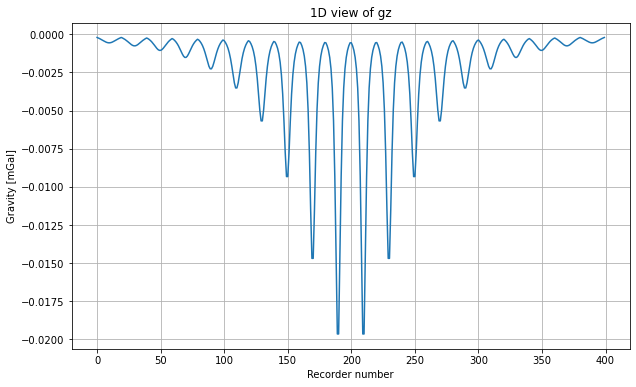

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(gz_rec) 
plt.title('1D view of gz')
plt.xlabel('Recorder number')
plt.ylabel('Gravity [mGal]')
plt.grid()
plt.show()

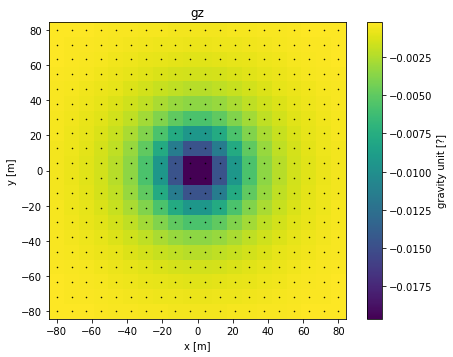

In [13]:
lxr=len(x_rec_slice)
lyr=len(y_rec_slice)


limx=max(x_rec_slice)+(x_rec_slice[1]-x_rec_slice[0])*0.5
limy=max(y_rec_slice)+(y_rec_slice[1]-y_rec_slice[0])*0.5

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.scatter(rec_coords[:,0],rec_coords[:,1],s=0.3,color='k')
plt.imshow(np.reshape(gz_rec,[lxr,lyr]),extent=[-limx,limx,-limy,limy])
plt.title('gz')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar(label="gravity unit [?]")

## Compare gravity calculation to "back of envelope" calculation ##


In [14]:
V=10**3 # Cube of 10*10*10m, i.e. 2x2x2 grid cells in current model set-up
r=25 # Distance from surface to mid-point of anomaly
rho=2000
g_test_SI=(rho*V*G)/(r**2)
g_test_mGal=g_test_SI*1e5
g_test_mGal

0.02135776

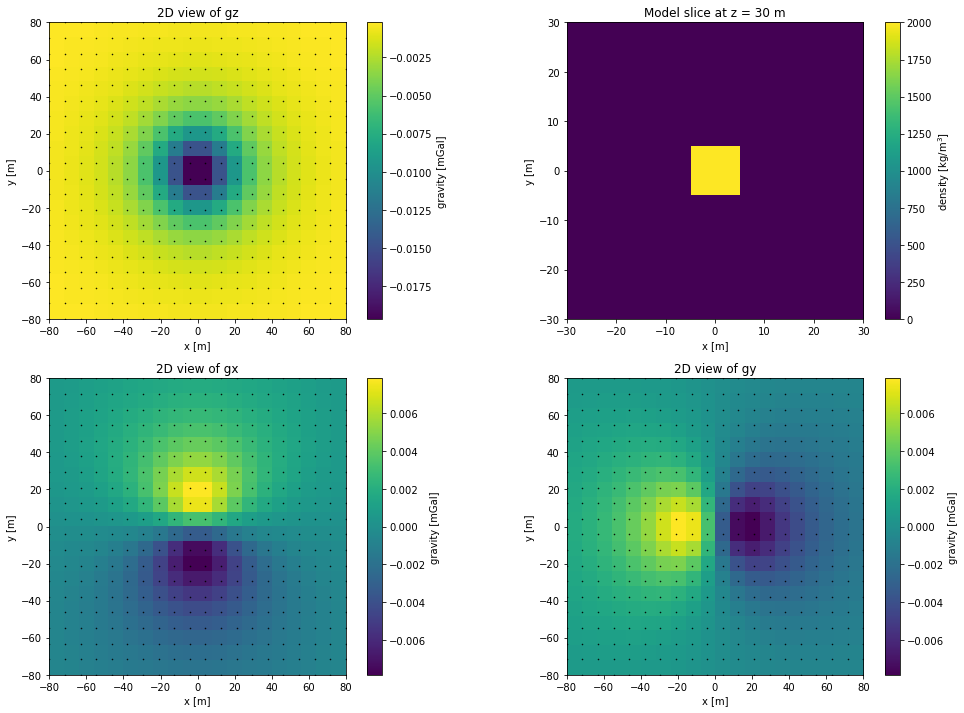

In [15]:
lxr=len(x_rec_slice)
lyr=len(y_rec_slice)

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.scatter(rec_coords[:,0],rec_coords[:,1],s=0.3,color='k')
plt.imshow(np.reshape(gz_rec,[lxr,lyr]),extent=[-80,80,-80,80])
plt.title('2D view of gz')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar(label="gravity [mGal]")

plt.subplot(2,2, 2)
plt.title("Model slice at z = 30 m")
plt.imshow(model2d[7][:][:],extent=[-30,30,-30,30])
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar(label="density [kg/m$^3$]")

plt.subplot(2, 2, 3)
plt.scatter(rec_coords[:,0],rec_coords[:,1],s=0.3,color='k')
plt.imshow(np.reshape(gx_rec,[lxr,lyr]),extent=[-80,80,-80,80])
plt.title('2D view of gx')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar(label="gravity [mGal]")

plt.subplot(2, 2, 4)
plt.scatter(rec_coords[:,0],rec_coords[:,1],s=0.3,color='k')
plt.imshow(np.reshape(gy_rec,[lxr,lyr]),extent=[-80,80,-80,80])
plt.title('2D view of gy')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.colorbar(label="gravity [mGal]")
plt.show()